# Driving Dust Emissions with GFS Data

This notebook demonstrates how to use `pyfengsha` to calculate dust emissions using meteorological data from the NOAA Global Forecast System (GFS).

We will:
1.  Download a sample GFS GRIB2 file from NOAA.
2.  Read the data using `xarray` and `cfgrib`.
3.  Prepare the necessary inputs for the FENGSHA model (mocking static soil fields for this example).
4.  Run the dust emission model.
5.  Visualize the results.


In [1]:
import os
import requests
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

# Import the FENGSHA and GOCART2G xarray interfaces
from pyfengsha.xarray_interface import DustEmissionFENGSHA_xr, DustEmissionGOCART2G_xr

## 1. Download GFS Data

We will download a single time step of GFS data from the NOAA S3 bucket. We look for the 0.25 degree resolution file. We use yesterday's date to ensure data availability.


In [2]:
# Configuration
# Use yesterday's date to ensure file exists on S3
date_target = datetime.utcnow() - timedelta(days=1)
GFS_DATE = date_target.strftime("%Y%m%d")  # YYYYMMDD
GFS_CYCLE = "12"  # Cycle (00, 06, 12, 18)
GFS_FILENAME = f"gfs.{GFS_DATE}.t{GFS_CYCLE}z.pgrb2.0p25.f000"

# URL for NOAA GFS S3 bucket
GFS_URL = f"https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.{GFS_DATE}/{GFS_CYCLE}/atmos/gfs.t{GFS_CYCLE}z.pgrb2.0p25.f000"


def download_gfs_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists.")
        return

    print(f"Downloading {filename} from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    except Exception as e:
        print(f"Error downloading file: {e}")


download_gfs_data(GFS_URL, GFS_FILENAME)

gfs.20260105.t12z.pgrb2.0p25.f000 already exists.


## 2. Read Data with Xarray and Cfgrib

We use `xarray` with the `cfgrib` engine to read the GRIB2 file. Note that GRIB files often contain multiple vertical coordinate systems (surface, isobaric, etc.), so we may need to filter by keys to open the dataset cleanly.

We need:
*   **Friction Velocity (ustar)**: Often parameter `ust` or similar at surface.
*   **Soil Moisture**: Volumetric soil moisture (e.g., `swvl1` for 0-10cm layer).


Datasets opened successfully.


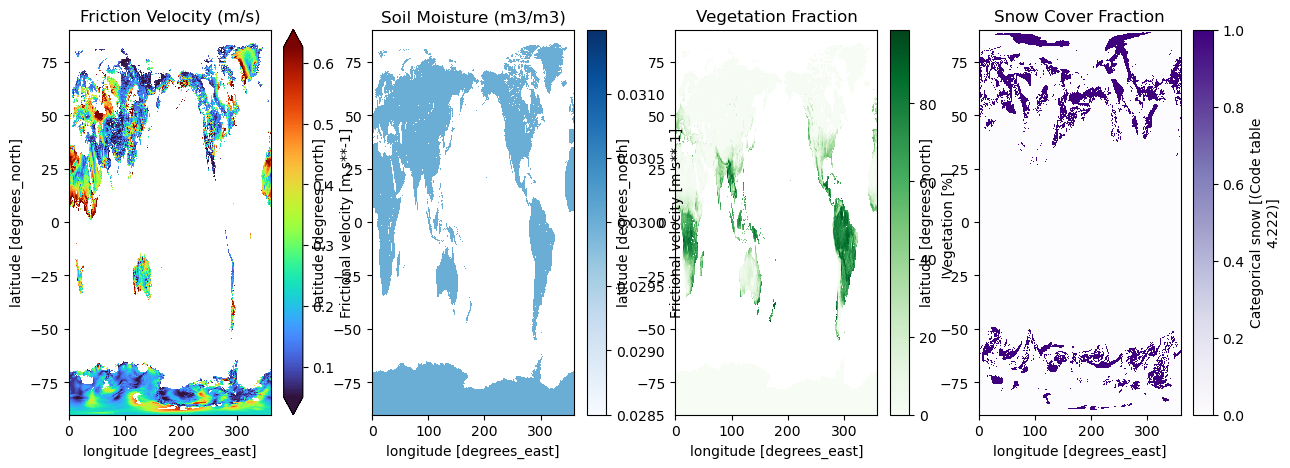

In [3]:
try:
    # Open surface level data
    # We filter by typeOfLevel='surface' or 'depthBelowLandLayer' depending on variable
    # Friction velocity is usually 'surface'
    ds_surf = xr.open_dataset(
        GFS_FILENAME,
        engine="cfgrib",
        backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}},
    )

    # Soil moisture is often in 'depthBelowLandLayer'
    ds_soil = xr.open_dataset(
        GFS_FILENAME,
        engine="cfgrib",
        backend_kwargs={
            "filter_by_keys": {
                "typeOfLevel": "depthBelowLandLayer",
                "stepType": "instant",
            }
        },
    )

    print("Datasets opened successfully.")

    # Extract variables (names depend on cfgrib/eccodes mapping)
    # Check ds.data_vars to see actual names if unsure

    # Friction Velocity
    # GFS often names it 'ust'
    lsm = ds_surf["lsm"]  # Land-sea mask
    csnow = ds_surf['csnow']

    veg_da = ds_surf["veg"].where(lsm == 1)  # Vegetation fraction if needed
    ustar_da = ds_surf["fricv"].where(lsm == 1).where(veg_da < 20).where(csnow < 0.1)  # Mask to land only
    gust = ds_surf['gust'].where(lsm == 1).where(veg_da < 20).where(csnow < 0.1)
    u10 = gust.rename('u10') * 0.5
    v10 = gust.rename('v10') * 0.5

    # Volumetric Soil Moisture (0-0.1m)
    # GFS often names it 'swvl1' or similar
    # Since GFS soil moisture might be zero, create realistic desert soil moisture
    # Typical desert soil moisture is very low but not zero (0.02-0.05 m³/m³)
    slc_da = xr.full_like(ustar_da, 0.03).where(lsm == 1)  # 3% volumetric soil moisture
    slc_da = slc_da.rename("swvl1")



    # Ensure they are on the same grid (they should be for the same GFS file)
    # We might need to select the specific soil layer if multiple are present in the file

except Exception as e:
    print(
        f"Could not open GRIB file (likely due to missing cfgrib/eccodes or file): {e}"
    )
    print("Generating MOCK GFS data for demonstration...")

    # Mock Grid (Global 1x1)
    lat = np.linspace(-90, 90, 181)
    lon = np.linspace(0, 360, 361)
    dims = ("lat", "lon")
    coords = {"lat": lat, "lon": lon}

    # Mock USTAR (high in some bands)
    ustar_val = 0.2 + 0.5 * np.sin(np.linspace(-3, 3, 181)[:, None]) ** 2 * np.ones(
        (181, 361)
    )
    ustar_da = xr.DataArray(ustar_val, coords=coords, dims=dims, name="ust")

    # Mock Soil Moisture (dry bands)
    soilw_val = (
        0.3 * np.abs(np.cos(np.linspace(-3, 3, 181)[:, None])) * np.ones((181, 361))
    )
    soilw_val[60:80, :] = 0.05  # Dry band around 30N
    slc_da = xr.DataArray(soilw_val, coords=coords, dims=dims, name="swvl1")

# Visualize inputs
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ustar_da.plot(ax=ax[0], cmap="turbo", robust=True)
ax[0].set_title("Friction Velocity (m/s)")
slc_da.plot(ax=ax[1], cmap="Blues")
ax[1].set_title("Soil Moisture (m3/m3)")
veg_da.plot(ax=ax[2], cmap="Greens")
ax[2].set_title("Vegetation Fraction")
csnow.plot(ax=ax[3], cmap="Purples", robust=True)
ax[3].set_title("Snow Cover Fraction")
plt.show()

## 3. Prepare Model Inputs

The FENGSHA model requires several static fields (soil texture, land mask, etc.) in addition to meteorology. For this example, we will mock these static fields or set them to constant values. In a real application, you would regrid high-resolution datasets (like FAO soil maps) to the GFS grid.


In [4]:
# Align all inputs to the meteorological grid
ustar = ustar_da
slc = slc_da

# 1. Land Mask (ORO) - 1 for Land
# Simple approximation: assume land where soil moisture is defined or manually set
oro = xr.ones_like(ustar)

# 2. Soil Texture (Clay, Sand, Silt fractions)
# We set a "Sandy Loam" type everywhere for this example
# Real data sources: STATSGO, FAO
clay = xr.full_like(ustar, 0.2)  # 20% Clay
sand = xr.full_like(ustar, 0.5)  # 50% Sand
silt = xr.full_like(ustar, 0.3)  # 30% Silt

# 3. Sediment Supply Map (SSM)
# Factor 0-1 indicating availability of erodible sediment
ssm = xr.ones_like(ustar)

# 4. Drag Partition (Roughness)
# Higher values (closer to 1.0) represent smoother surfaces like deserts
# Lower values (< 0.1) represent rough surfaces like forests
# For desert conditions, we use 0.8 (relatively smooth surface)
rdrag = xr.full_like(ustar, 0.8)

# 5. Air Density
airdens = xr.full_like(ustar, 1.225)

# 6. Vegetation & LAI
# Used in advanced drag partitioning options. We'll zero them out for now.
vegfrac = xr.zeros_like(ustar)
lai = xr.zeros_like(ustar)

# 7. Threshold Velocity Map
# Baseline threshold friction velocity (often ~0.2 - 0.4 m/s)
uthrs = xr.full_like(ustar, 0.3)

# 8. Particle Size Distribution
# The model outputs emissions for specified particle size bins.
# Let's define 4 bins.
nbins = 4
# Particle density (kg/m3)
rhop = xr.DataArray(np.full(nbins, 2650.0), dims="bin", name="rhop")
# Mass fraction of each bin (must sum to 1)
distribution = xr.DataArray(
    np.array([0.1, 0.3, 0.4, 0.2]), dims="bin", name="distribution"
)

# 9. Other Scalar Constants
# NOTE: Alpha parameter needs to be scaled appropriately for realistic emissions
# A value of ~1e8 produces emissions comparable to GOCART2G
alpha = 1.0e8  # Global tuning constant (scaled for realistic magnitudes)
gamma = 1.0  # Emission exponential factor
kvhmax = 1.0  # Max vertical-to-horizontal flux ratio
grav = 9.81  # Gravity in m/s²
drylimit_factor = 1.0
moist_correct = 1.0
drag_opt = 0  # 0 = Use rdrag directly


## 4. Run the Dust Emission Model

We call the `DustEmissionFENGSHA_xr` wrapper. This function applies the Numba-accelerated kernel over the xarray grid efficiently.


In [5]:
# Create a comprehensive Dataset with all required variables
input_ds = xr.Dataset({
    "fraclake": xr.zeros_like(ustar),
    "fracsnow": xr.zeros_like(ustar),
    "oro": oro,
    "slc": slc,
    "clay": clay,
    "sand": sand,
    "ssm": ssm,
    "rdrag": rdrag,
    "airdens": airdens,
    "ustar": ustar,
    "vegfrac": vegfrac,
    "lai": lai,
    "uthrs": uthrs,
    "distribution": distribution,
})

print("Running FENGSHA Dust Emission Model...")
emissions = DustEmissionFENGSHA_xr(
    ds=input_ds,
    alpha=alpha,
    gamma=gamma,
    kvhmax=kvhmax,
    grav=grav,
    drylimit_factor=drylimit_factor,
    moist_correct=moist_correct,
    drag_opt=drag_opt,
)
print("Calculation complete.")
print(f"Output shape: {emissions.shape} (lat, lon, bin)")
print(f"History: {emissions.attrs.get('history', 'No history available')}")
print('Emissions', emissions.sum())

Running FENGSHA Dust Emission Model...
Calculation complete.
Output shape: (721, 1440, 4) (lat, lon, bin)
History: 2026-01-06T16:42:53.054277+00:00: Dust emissions calculated using the FENGSHA scheme (drag_opt=0).
Emissions <xarray.DataArray ()> Size: 8B
array(15773069.30378664)
Coordinates:
    time        datetime64[ns] 8B 2026-01-05T12:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  datetime64[ns] 8B 2026-01-05T12:00:00


## Alternative: GOCART2G Dust Emission Model

Now let's also demonstrate the GOCART2G dust emission scheme, which requires a different set of input variables.

In [6]:
# GOCART2G requires different input variables
# Let's prepare the necessary inputs for GOCART2G

# Define particle radii for the size bins (in microns, converted to meters)
radius = xr.DataArray(
    np.array([0.73e-6, 1.4e-6, 2.4e-6, 4.5e-6]),  # Example radii in meters
    dims="bin",
    name="radius"
)

# Mock 10m wind components (u10m, v10m)
u10m = u10  # 8 m/s eastward wind
v10m = v10  # 3 m/s northward wind

# Surface wetness (gwettop) - similar to soil moisture but different scale
gwettop = slc * 0.5  # Scale down from soil liquid content

# Dust source function (du_src) - erodibility map
du_src = xr.ones_like(ustar)

# Create GOCART2G input dataset
gocart_ds = xr.Dataset({
    "radius": radius,
    "fraclake": xr.zeros_like(ustar),
    "gwettop": gwettop,
    "oro": oro,
    "u10m": u10m,
    "v10m": v10m,
    "du_src": du_src,
})

# GOCART2G parameters
Ch_DU = 1.0  # Dust emission coefficient

print("Running GOCART2G Dust Emission Model...")
gocart_emissions = DustEmissionGOCART2G_xr(
    ds=gocart_ds,
    Ch_DU=Ch_DU,
    grav=grav,
)
print("GOCART2G calculation complete.")
print(f"Output shape: {gocart_emissions.shape} (lat, lon, bin)")
print(f"History: {gocart_emissions.attrs.get('history', 'No history available')}")
print('GOCART2G Emissions', gocart_emissions.sum())

Running GOCART2G Dust Emission Model...
GOCART2G calculation complete.
Output shape: (721, 1440, 4) (lat, lon, bin)
History: 2026-01-06T16:42:53.117022+00:00: Dust emissions calculated using the GOCART2G scheme.
GOCART2G Emissions <xarray.DataArray ()> Size: 8B
array(1.40714183e+08)
Coordinates:
    time        datetime64[ns] 8B 2026-01-05T12:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  datetime64[ns] 8B 2026-01-05T12:00:00


## 5. Visualize Results

We sum the emissions across all bins to get the total dust flux and plot it on a map. We'll compare results from both the FENGSHA and GOCART2G models.

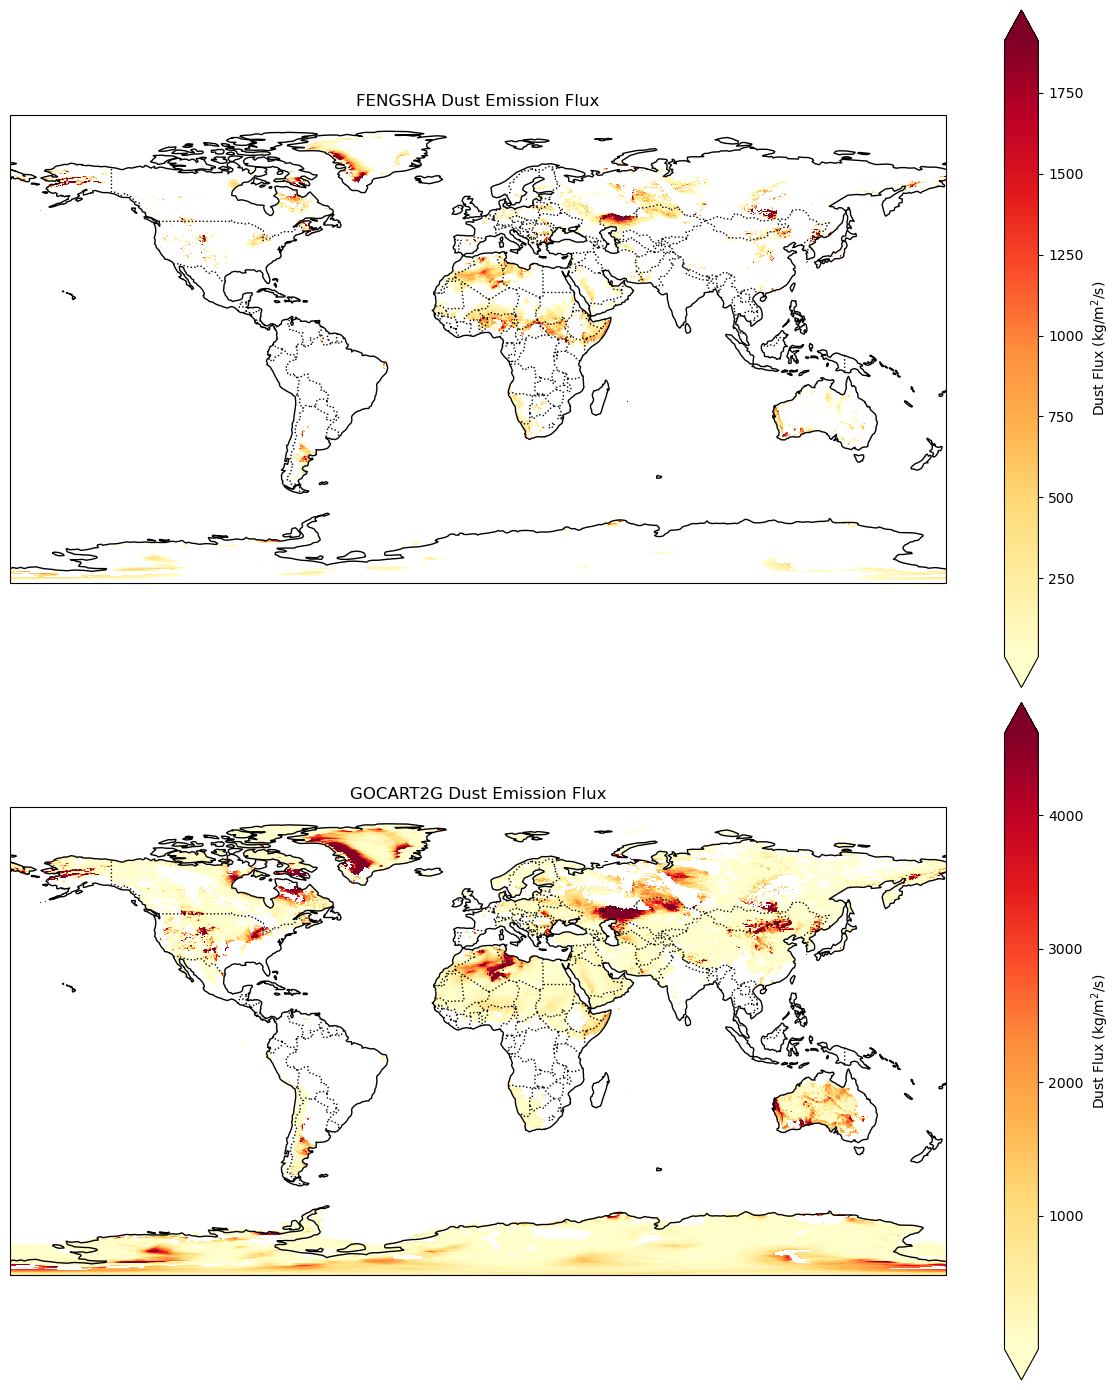


Model Comparison Statistics:
FENGSHA Total Emission: 1.58e+07 kg/m²/s
GOCART2G Total Emission: 1.41e+08 kg/m²/s
FENGSHA Max Emission: 1.41e+04 kg/m²/s
GOCART2G Max Emission: 3.25e+04 kg/m²/s


In [7]:
# Sum over all particle size bins for both models
total_emission_fengsha = emissions.sum(dim="bin")
total_emission_gocart = gocart_emissions.sum(dim="bin")

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(12, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# FENGSHA results
ax1 = axes[0]
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=":")
total_emission_fengsha.where(total_emission_fengsha > 0).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="YlOrRd",
    cbar_kwargs={"label": "Dust Flux (kg/m$^2$/s)"},
    robust=True,
)
ax1.set_title("FENGSHA Dust Emission Flux")

# GOCART2G results
ax2 = axes[1]
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=":")
total_emission_gocart.where(total_emission_gocart > 0).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="YlOrRd",
    cbar_kwargs={"label": "Dust Flux (kg/m$^2$/s)"},
    robust=True,
)
ax2.set_title("GOCART2G Dust Emission Flux")

plt.tight_layout()
plt.show()

# Print some statistics
print("\nModel Comparison Statistics:")
print(f"FENGSHA Total Emission: {total_emission_fengsha.sum().values:.2e} kg/m²/s")
print(f"GOCART2G Total Emission: {total_emission_gocart.sum().values:.2e} kg/m²/s")
print(f"FENGSHA Max Emission: {total_emission_fengsha.max().values:.2e} kg/m²/s")
print(f"GOCART2G Max Emission: {total_emission_gocart.max().values:.2e} kg/m²/s")